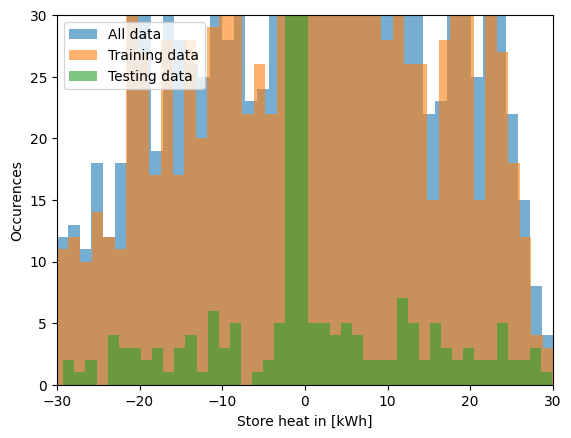

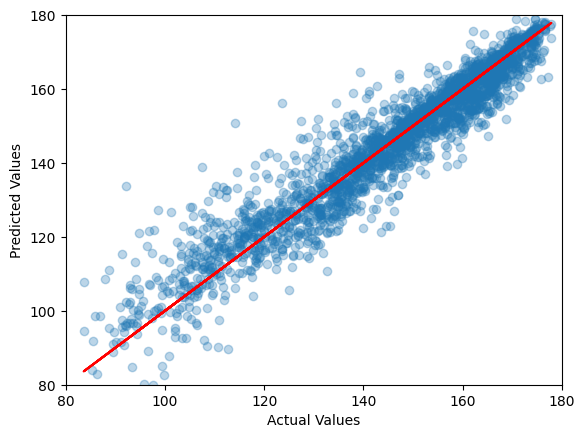

RMSE: 6.4
R-squared: 0.9
Cross-Validation RMSE: 6.8


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

df = pd.read_csv('oak_storage_data.csv')
X = df[[c for c in df.columns if 'initial' in c or 'store_heat_in' in c]]
y = df[[c for c in df.columns if 'final' in c]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

plt.hist(df['store_heat_in'], bins=50, label="All data", alpha=0.6)
plt.hist(X_train['store_heat_in'], bins=50, label="Training data", alpha=0.6)
plt.hist(X_test['store_heat_in'], bins=50, label="Testing data", alpha=0.6)
plt.xlabel("Store heat in [kWh]")
plt.ylabel("Occurences")
plt.xlim([-30,30])
plt.ylim([0,30])
plt.legend()
plt.show()

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

plt.scatter(y_test, y_pred_ridge, alpha=0.3)
plt.plot(y_test, y_test, color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.xlim([80,180])
plt.ylim([80,180])
plt.show()

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
ridge_cv_score = cross_val_score(ridge_model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"RMSE: {round(np.sqrt(abs(mse_ridge)),1)}")
print(f"R-squared: {round(r2_ridge,1)}")
print(f"Cross-Validation RMSE: {round(np.sqrt(abs(ridge_cv_score.mean())),1)}")

In [2]:
def kmeans(data, k=3, max_iters=100, tol=1e-4):
    data = np.array(data).reshape(-1, 1)
    centroids = data[np.random.choice(len(data), k, replace=False)]
    for _ in range(max_iters):
        labels = np.argmin(np.abs(data - centroids.T), axis=1)
        new_centroids = np.zeros_like(centroids)
        for i in range(k):
            cluster_points = data[labels == i]
            if len(cluster_points) > 0:
                new_centroids[i] = cluster_points.mean()
            else:
                new_centroids[i] = data[np.random.choice(len(data))]
        if np.all(np.abs(new_centroids - centroids) < tol):
            break
        centroids = new_centroids
    return labels

def get_model_from_temperatures(tank_temps):
    if isinstance(tank_temps, list):
        tank_temps = {
            f'tank{tank}-depth{depth}': tank_temps[tank*4 + depth] for tank in range(3) for depth in range(4)
        }

    # Process layer temperatures
    layer_temps = [v for k,v in tank_temps.items()]
    iter_count = 0
    print(f"Before processing: {layer_temps}")
    while sorted(layer_temps, reverse=True) != layer_temps and iter_count<20:
        iter_count += 1
        layer_temps = [tank_temps[list(tank_temps.keys())[0]]]
        for layer in tank_temps:
            if tank_temps[layer] > layer_temps[-1]:
                mean = round((layer_temps[-1] + tank_temps[layer]) / 2)
                layer_temps[-1] = mean
                layer_temps.append(mean)
            else:
                layer_temps.append(tank_temps[layer])
        for i, layer in enumerate(tank_temps):
            tank_temps[layer] = layer_temps[i]
        if iter_count == 20:
            layer_temps = sorted(layer_temps, reverse=True)
    print(f"After processing: {layer_temps}")

    # Cluster 10 times and select the clustering with the highest top temperature
    data = layer_temps.copy()
    clustering_runs = []
    for i in range(10):
        labels = kmeans(data, k=3)
        cluster_0 = sorted([data[i] for i in range(len(data)) if labels[i] == 0], reverse=True)
        cluster_1 = sorted([data[i] for i in range(len(data)) if labels[i] == 1], reverse=True)
        cluster_2 = sorted([data[i] for i in range(len(data)) if labels[i] == 2], reverse=True)
        cluster_top = max(cluster_0, cluster_1, cluster_2, key=lambda x: np.mean(x) if len(x)>0 else 0)
        top_temp = sum(cluster_top)/len(cluster_top)
        clustering_runs.append({
            'cluster_0': cluster_0,
            'cluster_1': cluster_1,
            'cluster_2': cluster_2,
            'top_temp': top_temp
        })
    best_run = max(clustering_runs, key=lambda x: x['top_temp'])
    cluster_0 = best_run['cluster_0']
    cluster_1 = best_run['cluster_1']
    cluster_2 = best_run['cluster_2']

    # Dealing with 3 clusters
    if cluster_0 and cluster_1 and cluster_2:
        cluster_top = max(cluster_0, cluster_1, cluster_2, key=lambda x: sum(x)/len(x))
        cluster_bottom = min(cluster_0, cluster_1, cluster_2, key=lambda x: sum(x)/len(x))
        cluster_middle = [
            cluster_x for cluster_x in [cluster_0, cluster_1, cluster_2]
            if cluster_x != cluster_top
            and cluster_x != cluster_bottom
            ][0]
        print(f"{cluster_top}, {cluster_middle}, {cluster_bottom}")

        thermocline1 = max(1, len(cluster_top))
        thermocline2 = thermocline1 + len(cluster_middle)
        print(f"Thermocline 1: {thermocline1}/12, thermocline 2: {thermocline2}/12")

        top_temp = round(sum(cluster_top)/len(cluster_top))
        middle_temp = round(sum(cluster_middle)/len(cluster_middle))
        bottom_temp = round(sum(cluster_bottom)/len(cluster_bottom))
        print(f"{top_temp}({thermocline1}){middle_temp}({thermocline2}){bottom_temp}")
        return top_temp, middle_temp, bottom_temp, thermocline1, thermocline2

    # Dealing with less than 3 clusters
    else:
        if cluster_0 and cluster_2:
            cluster_1 = cluster_2
        elif cluster_1 and cluster_2:
            cluster_0 = cluster_2
        # Two clusters
        if cluster_0 and cluster_1:
            cluster_top = max(cluster_0, cluster_1, key=lambda x: sum(x)/len(x))
            cluster_bottom = min(cluster_0, cluster_1, key=lambda x: sum(x)/len(x))
            thermocline1 = len(cluster_top)
            top_temp = round(sum(cluster_top)/len(cluster_top))
            bottom_temp = round(sum(cluster_bottom)/len(cluster_bottom))
            print(f"{top_temp}({thermocline1}){bottom_temp}")
            return top_temp, None, bottom_temp, thermocline1, None
        # Single cluster
        else:
            cluster_top = max(cluster_0, cluster_1, cluster_2, key=lambda x: len(x))
            top_temp = round(sum(cluster_top)/len(cluster_top))
            thermocline1 = 12
            print(f"{top_temp}({thermocline1})")
            return top_temp, None, None, thermocline1, None

In [3]:
layers = X_test.iloc[30].tolist()[1:]
tank_temps = {
    'tank1-depth1': layers[0],
    'tank1-depth2': layers[1],
    'tank1-depth3': layers[2],
    'tank1-depth4': layers[3],
    'tank2-depth1': layers[4],
    'tank2-depth2': layers[5],
    'tank2-depth3': layers[6],
    'tank2-depth4': layers[7],
    'tank3-depth1': layers[8],
    'tank3-depth2': layers[9],
    'tank3-depth3': layers[10],
    'tank3-depth4': layers[11],
}
get_model_from_temperatures(tank_temps)

Before processing: [159.2, 145.1, 144.7, 141.5, 142.8, 143.6, 141.9, 133.6, 124.9, 118.3, 108.7, 117.6]
After processing: [159.2, 159.2, 159.2, 145.1, 144.7, 142, 142, 142, 141.9, 133.6, 124.9, 118.3, 113]
[159.2, 159.2, 159.2], [145.1, 144.7, 142, 142, 142, 141.9, 133.6], [124.9, 118.3, 113]
Thermocline 1: 3/12, thermocline 2: 10/12
159(3)142(10)119


(159, 142, 119, 3, 10)

In [4]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

class TankStatePlotter():
    def __init__(self, initial, final, predicted, store_heat_in):
        self.initial = initial
        self.final = final
        self.predicted = predicted
        self.title = f"To storage: {store_heat_in} kWh"
        self.plot()

    def plot(self):
        overall_min = min(min(self.initial), min(self.final), min(self.predicted))
        overall_max = max(max(self.initial), max(self.final), max(self.predicted))
        norm = Normalize(vmin=overall_min, vmax=overall_max)
        cmap = matplotlib.colormaps['Reds'] 

        for i in range(12):
            layer_color = cmap(norm(self.initial[i]))
            plt.bar([0], 1, bottom=11-i, color=layer_color, width=0.8)
            plt.text(0, 11-i+0.5, f'{self.initial[i]}', ha='center', va='center', color='black', alpha=0.5)

            layer_color = cmap(norm(self.final[i]))
            plt.bar([1], 1, bottom=11-i, color=layer_color, width=0.8)
            plt.text(1, 11-i+0.5, f'{self.final[i]}', ha='center', va='center', color='black', alpha=0.5)

            layer_color = cmap(norm(self.predicted[i]))
            plt.bar([3], 1, bottom=11-i, color=layer_color, width=0.8)
            plt.text(3, 11-i+0.5, f'{self.predicted[i]}', ha='center', va='center', color='black', alpha=0.5)

        top_temp, middle_temp, bottom_temp, thermocline1, thermocline2 = get_model_from_temperatures(self.final)
        top_color = cmap(norm(top_temp))
        middle_color = cmap(norm(middle_temp))
        bottom_color = cmap(norm(bottom_temp))
        
        plt.bar([2], height=thermocline1, bottom=12-thermocline1, color=top_color, width=0.8)
        plt.text(2, 12-thermocline1+thermocline1/2, f'{top_temp}', ha='center', va='center', color='black', alpha=0.5)
        plt.bar([2], height=thermocline2-thermocline1, bottom=12-thermocline2, color=middle_color, width=0.8)
        plt.text(2, 12-thermocline2+(thermocline2-thermocline1)/2, f'{middle_temp}', ha='center', va='center', color='black', alpha=0.5)
        plt.bar([2], height=12-thermocline2, bottom=0, color=bottom_color, width=0.8)
        plt.text(2, (12-thermocline2)/2, f'{bottom_temp}', ha='center', va='center', color='black', alpha=0.5)

        top_temp, middle_temp, bottom_temp, thermocline1, thermocline2 = get_model_from_temperatures(self.predicted)
        top_color = cmap(norm(top_temp))
        middle_color = cmap(norm(middle_temp))
        bottom_color = cmap(norm(bottom_temp))
        
        plt.bar([4], height=thermocline1, bottom=12-thermocline1, color=top_color, width=0.8)
        plt.text(4, 12-thermocline1+thermocline1/2, f'{top_temp}', ha='center', va='center', color='black', alpha=0.5)
        plt.bar([4], height=thermocline2-thermocline1, bottom=12-thermocline2, color=middle_color, width=0.8)
        plt.text(4, 12-thermocline2+(thermocline2-thermocline1)/2, f'{middle_temp}', ha='center', va='center', color='black', alpha=0.5)
        plt.bar([4], height=12-thermocline2, bottom=0, color=bottom_color, width=0.8)
        plt.text(4, (12-thermocline2)/2, f'{bottom_temp}', ha='center', va='center', color='black', alpha=0.5)

        plt.xticks([0,1,2,3,4], ['Before', 'After', '-', 'Predicted After', '-'])
        plt.yticks([])
        plt.title(self.title, fontsize=12)
        plt.show()



Before processing: [141.7, 134.0, 137.2, 128.0, 123.7, 109.0, 107.5, 107.2, 107.4, 105.3, 102.1, 106.5]
After processing: [141.7, 141.7, 136, 136, 128.0, 123.7, 109.0, 107.5, 107, 107, 105.3, 104, 104]
[141.7, 141.7], [136, 136, 128.0, 123.7], [109.0, 107.5, 107, 107, 105.3, 104, 104]
Thermocline 1: 2/12, thermocline 2: 6/12
142(2)131(6)106
Before processing: [141.4, 133.2, 134.6, 129.2, 132.1, 125.1, 113.3, 106.2, 107.3, 97.9, 93.0, 96.1]
After processing: [141.4, 141.4, 134, 134, 131, 131, 125.1, 113.3, 107, 107, 97.9, 95, 95]
[141.4, 141.4], [134, 134, 131, 131, 125.1], [113.3, 107, 107, 97.9, 95, 95]
Thermocline 1: 2/12, thermocline 2: 7/12
141(2)131(7)103


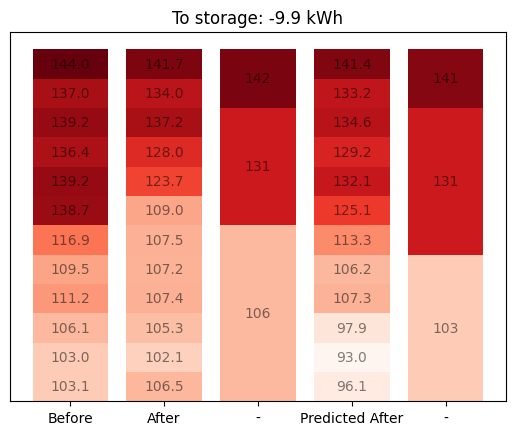


Before processing: [174.1, 165.8, 171.1, 166.2, 170.9, 171.6, 169.4, 142.3, 133.4, 114.5, 110.3, 119.3]
After processing: [174.1, 174.1, 174.1, 174.1, 174.1, 174.1, 174.1, 174.1, 174.1, 174.1, 168, 168, 168]
174(10)168


TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

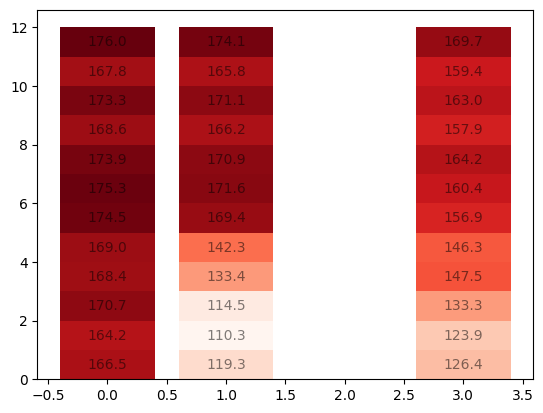

In [5]:
for i in range(20):
    print('')
    store_heat_in = X_test.iloc[i].tolist()[0]
    if abs(store_heat_in) < 2:
        continue
    initial_temp = X_test.iloc[i].tolist()[1:]
    final_temp = y_test.iloc[i].tolist()
    final_temp_pred = [round(float(x),1) for x in list(y_pred_ridge[i])]
    t = TankStatePlotter(initial_temp, final_temp, final_temp_pred, store_heat_in)